[2017-09-05 22:55:26,516] Making new env: Pong-v0


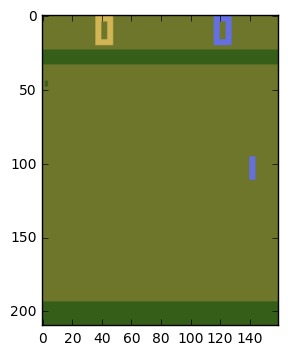

In [84]:
import gym
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
env = gym.make("Pong-v0")
env.reset()
render = lambda: plt.imshow(env.render(mode='rgb_array'))
render()
plt.show()

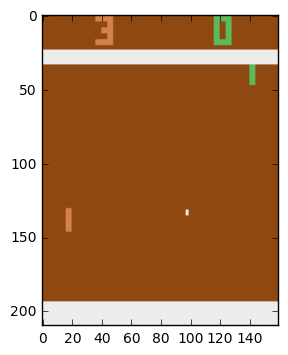

In [216]:
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [217]:
env.reset()
print(env.action_space)
env.unwrapped.get_action_meanings()

Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

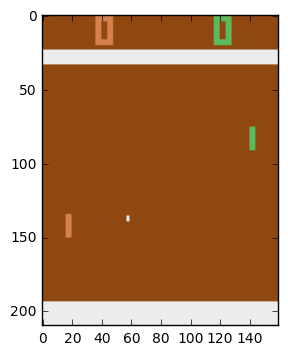

In [246]:
#1 does nothing, 2 goes up, 3 goes down
env.step(1)
render()
plt.show()

In [247]:
import tensorflow as tf
import numpy as np
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [256]:
sess = tf.InteractiveSession()

# Create 100 phony x, y data points in NumPy, y = x * 0.1 + 0.3
np.random.seed(1)
x_data = np.random.rand(1).astype("float32")
y_data = (x_data < 0.5).astype("float32")

x = tf.placeholder(tf.float32, shape=[None, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])


# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but Tensorflow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0, seed=1))
b = tf.Variable(tf.zeros([1]))
logits = W * x_data + b


solo_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                        labels=y_data, logits=logits)
cross_entropy = tf.reduce_mean(solo_cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(cross_entropy)

tf.global_variables_initializer().run()

# Fit the line.
for step in range(10):
    print (step, sess.run(W), sess.run(b), sess.run(logits),
           sess.run(solo_cross_entropy) )
    sess.run(train)

    
#learn y = x * 0.1 + 0.3
x_data = np.random.rand(100).astype(np.float32)
y_data = x_data * 0.1 + 0.3

# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but TensorFlow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * x_data + b

# Minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(y - y_data))
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.global_variables_initializer()

# Launch the graph.
sess = tf.Session(config=config)
sess.run(init)

# Fit the line.
for step in range(201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))

# Learns best fit is W: [0.1], b: [0.3]

0 [-0.52192521] [ 0.] [-0.21765429] 0.0
1 [-0.52192521] [ 0.] [-0.21765429] 0.0
2 [-0.52192521] [ 0.] [-0.21765429] 0.0
3 [-0.52192521] [ 0.] [-0.21765429] 0.0
4 [-0.52192521] [ 0.] [-0.21765429] 0.0
5 [-0.52192521] [ 0.] [-0.21765429] 0.0
6 [-0.52192521] [ 0.] [-0.21765429] 0.0
7 [-0.52192521] [ 0.] [-0.21765429] 0.0
8 [-0.52192521] [ 0.] [-0.21765429] 0.0
9 [-0.52192521] [ 0.] [-0.21765429] 0.0


In [250]:
y_data

array([ 1.], dtype=float32)

In [75]:
sess.run(tf.nn.softmax([-1.]))

array([ 1.], dtype=float32)